In [1]:
# --- Block 0: imports & global configuration ---
from __future__ import annotations

# Standard library
from pathlib import Path
import json
import functools
import random
import os

# Third-party
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt

from scipy import signal
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras # type: ignore
from tensorflow.keras import layers # type: ignore

# Reproducibility: set all relevant random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Dataset root and label namespaces
DATA_ROOT = Path("../data").resolve()               # - DATA_ROOT: folder that contains the audio + sidecar JSON files
TASKS = ["coughing", "heartsounds"]                 # - TASKS:     top-level subfolders or class labels you expect
MICS  = ["new_microphone", "old_microphone"]        # - MICS:      microphone variants (subfolders)

# Segment & audio constants
SEG_DUR = 3.0        # - SEG_DUR:  fixed segment length (seconds)
SR_FIXED = 15750     # - SR_FIXED: fixed sampling rate expected by the pipeline (Hz)

# STFT parameters
N_FFT = 1024    # - N_FFT: FFT window size
HOP   = 256     # - HOP:   hop length (samples) between frames
WIN   = "hann"  # - WIN:   analysis window function

# Derived shapes
F_BINS = 1 + N_FFT // 2                                     # - F_BINS:   number of unique frequency bins in a one-sided FFT
T_TARGET = librosa.time_to_frames(                          # - T_TARGET: number of frames that fit in a SEG_DUR-long segmen
    SEG_DUR, sr=SR_FIXED, hop_length=HOP, n_fft=N_FFT       # at SR_FIXED with the given STFT params (used to enforce
)                                                           # a fixed input shape for the NN)

# Model output directory (will be created if it does not exist)
MODEL_DIR = Path("./models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)


In [2]:
# Block A: Dataset parsing and loading functions

def find_wavs_and_jsons(root: Path) -> pd.DataFrame:
    """
    Return a DataFrame with one row per .wav file.
    Columns: path, relpath, task, mic, json_path
    """
    rows = []
    for task in TASKS:
        for mic in MICS:
            base = root / task / mic
            if not base.is_dir():
                continue
            # Find all .wav files under this task/mic folder (recursively)
            for wav in sorted(base.rglob("*.wav")):
                # Assume a sidecar .json with the same stem (if it exists)
                js = wav.with_suffix(".json")
                rows.append({
                    "path": str(wav.resolve()),                          # absolute path to the .wav
                    "relpath": str(wav.relative_to(root).as_posix()),    # path relative to dataset root
                    "task": task,                                         # task/class name
                    "mic": mic,                                           # microphone variant
                    "json_path": str(js.resolve()) if js.exists() else None,  # sidecar json if present
                })
    df = pd.DataFrame(rows).sort_values(["task", "mic", "relpath"]).reset_index(drop=True)
    return df


def read_segments_from_json(json_path: Path) -> list[dict]:
    """
    Read segments from a sidecar .json (same structure as the example).
    Returns a list of dicts with keys:
      seg_id, t_start, t_end, dur, labels (list[str])
    """
    with open(json_path, "r", encoding="utf-8") as f:
        d = json.load(f)

    segs = d.get("segments", [])
    out: list[dict] = []

    for s in segs:
        # Convert start/end to float seconds
        t0 = float(s["t_start"])
        t1 = float(s["t_end"])
        out.append({
            "seg_id": s["id"],                     # unique segment ID
            "t_start": t0,                         # start time (s)
            "t_end": t1,                           # end time (s)
            "dur": t1 - t0,                        # duration (s)
            "labels": list(s.get("labels", [])),   # optional labels
        })
    return out


def build_segments_table(df_files: pd.DataFrame) -> pd.DataFrame:
    """
    Build a DataFrame with one row per segment.
    Columns: path, relpath, task, mic, seg_id, t_start, t_end, dur, labels
    """
    rows: list[dict] = []

    # Iterate over files; for each file that has a JSON, expand its segments
    for _, r in df_files.iterrows():
        if r["json_path"] is None:
            continue
        segs = read_segments_from_json(Path(r["json_path"]))
        for s in segs:
            rows.append({
                "path": r["path"],
                "relpath": r["relpath"],
                "task": r["task"],
                "mic": r["mic"],
                "seg_id": s["seg_id"],
                "t_start": s["t_start"],
                "t_end": s["t_end"],
                "dur": s["dur"],
                "labels": s["labels"],
            })

    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(["task", "mic", "relpath", "t_start"]).reset_index(drop=True)
    return df


In [3]:
# Load Dataset
df_files = find_wavs_and_jsons(DATA_ROOT)
print(f"Aantal .wav-bestanden: {len(df_files)}")
display(df_files.head(5))

Aantal .wav-bestanden: 40


,path,relpath,task,mic,json_path
0,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...
1,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_2.wav,coughing,new_microphone,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...
2,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_3.wav,coughing,new_microphone,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...
3,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_4.wav,coughing,new_microphone,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...
4,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_5.wav,coughing,new_microphone,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...


In [4]:
# Load Dataset segments
df_segs  = build_segments_table(df_files)
print(f"Aantal segmenten: {len(df_segs)}")
display(df_segs.head(5))

Aantal segmenten: 369


,path,relpath,task,mic,seg_id,t_start,t_end,dur,labels
0,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,90084a4e-8a76-43e2-a4dc-da7b6f91737f,1.74,4.74,3.0,[Hoest]
1,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,8b5383c1-b95b-49b6-89b4-4a0534268fad,6.91,9.91,3.0,[Hoest]
2,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,9d213259-75ac-428e-83e2-10dbe74a88e3,11.93,14.93,3.0,[Hoest]
3,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,c2b67ec8-0263-4b8a-be39-088835a9678f,16.77,19.77,3.0,[Hoest]
4,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,coughing/new_microphone/cough_1.wav,coughing,new_microphone,e712c1eb-c012-4b39-bf22-b9c94126352d,21.38,24.38,3.0,[Hoest]


In [5]:
# Block B: audio & spectrogram helpers

@functools.lru_cache(maxsize=2048)
def load_audio_cached(wav_path: str):
    """
    Load mono audio samples and the sample rate from disk.

    Returns
    -------
    y : np.ndarray (float32)
        Mono signal. If the file is stereo, channels are averaged.
    sr : int
        Sampling rate in Hz.
    """
    y, sr = sf.read(wav_path, dtype="float32", always_2d=False)
    if y.ndim == 2:
        # Stereo -> mono by averaging channels
        y = y.mean(axis=1)
    return y.astype(np.float32), int(sr)

def slice_seconds(y: np.ndarray, sr: int, t0: float, t1: float) -> np.ndarray:
    """
    Return the slice of y between t0 and t1 (in seconds).
    Indices are clamped to the valid signal range.
    """
    a = max(0, int(round(t0 * sr)))
    b = min(len(y), int(round(t1 * sr)))
    return y[a:b]

# Band-pass profiles (broader / task-dependent)
BAND_COUGH   = (80.0, 3000.0)   # Coughing vs Normal
BAND_HEART   = (20.0, 600.0)    # Heart-related segments
BAND_DEFAULT = (30.0, 3000.0)

def bandpass_filter(y: np.ndarray, fs: int, fc=(30.0, 3000.0), order=4, zero_phase=True) -> np.ndarray:
    """
    Butterworth band-pass filter. By default uses zero-phase (filtfilt).

    Parameters
    ----------
    y : np.ndarray
        Input signal.
    fs : int
        Sampling rate (Hz).
    fc : tuple(float, float)
        (low_cut, high_cut) in Hz.
    order : int
        Filter order.
    zero_phase : bool
        If True, apply forward+backward filtering (no phase shift).

    Returns
    -------
    np.ndarray (float32)
        Filtered signal.
    """
    low, high = fc
    # Keep high cutoff below Nyquist for numerical stability
    high = min(high, fs / 2 - 1.0)
    sos = signal.butter(order, [low, high], btype="bandpass", fs=fs, output="sos")
    y_filt = signal.sosfiltfilt(sos, y) if zero_phase else signal.sosfilt(sos, y)
    return y_filt.astype(np.float32) # type: ignore

def stft_db_fixed(y: np.ndarray, sr: int, n_fft=N_FFT, hop_length=HOP, win=WIN, t_target=None) -> np.ndarray:
    """
    Compute |STFT| -> dB and fix the time axis to a constant width.

    Steps:
    - STFT magnitude -> dB
    - Pad/trim frames to a fixed width (t_target)
    - Clip to [-80, 0] dB
    - Normalize to [0, 1] so energy contrast is preserved

    Output shape: (F, T)
    """
    if t_target is None:
        t_target = librosa.time_to_frames(SEG_DUR, sr=sr, hop_length=hop_length, n_fft=n_fft)

    # STFT complex matrix
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=win, center=True)

    # Magnitude -> dB (ref=1.0 so absolute scale; we normalize below)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=1.0)

    # Force a fixed number of time frames (pad or trim)
    S_db = librosa.util.fix_length(S_db, size=int(t_target), axis=1)

    # Clip dynamic range to [-80, 0] dB and scale to [0, 1]
    S_db = np.clip(S_db, -80.0, 0.0)
    S_img = (S_db + 80.0) / 80.0

    return S_img.astype(np.float32)

def augment_wave(y: np.ndarray, sr: int, p=0.5) -> np.ndarray:
    """
    Lightweight waveform augmentation (training only):
    - small time shift
    - random gain
    - low-level Gaussian noise

    Applied with probability p.
    """
    if np.random.rand() > p:
        return y

    # Random circular shift up to ±50 ms
    shift = np.random.randint(-int(0.05 * sr), int(0.05 * sr))
    y = np.roll(y, shift)

    # Random gain between -2 dB and +2 dB
    gain = 10 ** (np.random.uniform(-2, 2) / 20.0)
    y = y * gain

    # Add low-amplitude noise scaled by signal std (with a floor of 1.0)
    noise = np.random.normal(0, 0.005 * max(1.0, y.std()), size=len(y)).astype(np.float32)

    return (y + noise).astype(np.float32)


In [6]:
# Block C: label mapping to {Normaal, Hoest, Hart}

def map_class_tag(row: pd.Series) -> str:
    """
    Define a 3-class tag:
    - 'Hart'    : all segments from heartsounds/
    - 'Hoest'   : segments from coughing/ that contain label 'Hoest'
    - 'Normaal' : segments from coughing/ without 'Hoest' (e.g., 'Normaal')
    """
    # If the task folder is 'heartsounds', force class 'Hart'
    if row["task"] == "heartsounds":
        return "Hart"

    # Otherwise (task='coughing'), check if any label equals 'Hoest' (case-insensitive)
    labels = row.get("labels", [])
    has_hoest = any(str(lbl).lower() == "hoest" for lbl in labels)

    # If 'Hoest' present -> 'Hoest', else treat as 'Normaal'
    return "Hoest" if has_hoest else "Normaal"


# Add a 3-class column to the segments table
df_segs = df_segs.copy()
df_segs["class_tag"] = df_segs.apply(map_class_tag, axis=1)

# Quick class distribution check
display(df_segs["class_tag"].value_counts())


def make_binary_subset(df: pd.DataFrame, class_a: str, class_b: str) -> pd.DataFrame:
    """
    Keep only two classes (class_a, class_b) and create:
      - y      : integer target {0,1}
      - group  : grouping key per file for leakage-free splits
    """
    # Filter to the two classes of interest
    sub = df[df["class_tag"].isin([class_a, class_b])].copy().reset_index(drop=True)

    # Map class_a -> 0, class_b -> 1
    sub["y"] = sub["class_tag"].map({class_a: 0, class_b: 1}).astype("int64")

    # Group by file (relpath) so train/val/test splits don't leak segments from the same file
    sub["group"] = sub["relpath"]

    return sub


class_tag
Hart       200
Normaal    115
Hoest       54
Name: count, dtype: int64

In [7]:
# Block D: split diagnostics

def check_split_counts(df_train, df_val, df_test, name: str = "") -> None:
    """
    Print the class counts (value counts of column 'y') for train/val/test splits.

    Parameters
    ----------
    df_train, df_val, df_test : pandas.DataFrame
        DataFrames that each contain a target column 'y'.
    name : str, optional
        A label to include in the printout (e.g., the experiment name).
    """
    def counts(df):
        # Compute value counts for the target column 'y' and convert to plain ints
        vc = df["y"].value_counts().to_dict()
        return {int(k): int(v) for k, v in vc.items()}

    # Print a compact summary line with class distributions per split
    print(f"[{name}] y-train {counts(df_train)} | y-val {counts(df_val)} | y-test {counts(df_test)}")


In [8]:
# Block E: balanced splits + feature building
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

SEED = 42

def _try_group_split(df_sub, test_size: float, val_size: float, seed: int):
    """
    One attempt at a group-aware split:
    - First split df_sub -> trainval / test by 'group'
    - Then split trainval -> train / val by 'group'
    """
    # First split: hold out test set, grouping by file to avoid leakage
    gss1 = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    idx_trainval, idx_test = next(gss1.split(df_sub, df_sub["y"], groups=df_sub["group"]))
    df_trainval = df_sub.iloc[idx_trainval].reset_index(drop=True)
    df_test     = df_sub.iloc[idx_test].reset_index(drop=True)

    # Second split: from trainval, carve out validation set (also group-aware)
    gss2 = GroupShuffleSplit(n_splits=1, test_size=val_size, random_state=seed + 1)
    idx_train, idx_val = next(gss2.split(df_trainval, df_trainval["y"], groups=df_trainval["group"]))
    df_train = df_trainval.iloc[idx_train].reset_index(drop=True)
    df_val   = df_trainval.iloc[idx_val].reset_index(drop=True)
    return df_train, df_val, df_test


def balanced_group_split(df_sub, test_size: float = 0.2, val_size: float = 0.1,
                         seed: int = SEED, max_tries: int = 200):
    """
    Repeat group-aware splits until train/val/test each contain both classes (0 and 1).

    Raises
    ------
    RuntimeError
        If a balanced split cannot be found within `max_tries`.
    """
    rng = np.random.RandomState(seed)
    for _ in range(max_tries):
        s = int(rng.randint(0, 10_000))  # vary the random seed per attempt
        df_train, df_val, df_test = _try_group_split(df_sub, test_size, val_size, s)
        ok_train = df_train["y"].nunique() == 2
        ok_val   = df_val["y"].nunique() == 2
        ok_test  = df_test["y"].nunique() == 2
        if ok_train and ok_val and ok_test:
            return df_train, df_val, df_test
    raise RuntimeError("No balanced group-split found (dataset too imbalanced?)")


def rows_to_images(rows, band=(30.0, 3000.0), do_aug: bool = False):
    """
    Convert segment rows into a 4D tensor (N, F, T, 1):
    - Load audio
    - Slice to segment
    - Optional waveform augmentation (training only)
    - Band-pass filter
    - STFT->dB with fixed time width
    """
    X = []
    for _, r in rows.iterrows():
        y, sr = load_audio_cached(r["path"])          # load audio (cached)
        y = slice_seconds(y, sr, r["t_start"], r["t_end"])  # segment slice
        if do_aug:
            y = augment_wave(y, sr)                   # small time shift / gain / noise
        y = bandpass_filter(y, sr, fc=band, order=4, zero_phase=True)
        S = stft_db_fixed(y, sr)                      # shape (F, T)
        X.append(S[..., None])                        # add channel dim -> (F, T, 1)
    return np.stack(X, axis=0)                        # -> (N, F, T, 1)


def normalize_datasets(X_train: np.ndarray, X_val: np.ndarray, X_test: np.ndarray):
    """
    Global z-score using train statistics; apply the same normalization to val/test.
    """
    mu = X_train.mean(dtype=np.float64)
    sd = X_train.std(dtype=np.float64) + 1e-8
    X_train = ((X_train - mu) / sd).astype(np.float32)
    X_val   = ((X_val   - mu) / sd).astype(np.float32)
    X_test  = ((X_test  - mu) / sd).astype(np.float32)
    return X_train, X_val, X_test


def build_numpy_sets_balanced(df_sub, band=(30.0, 3000.0)):
    """
    End-to-end:
    - Balanced, group-aware split (train/val/test)
    - Feature extraction to (N, F, T, 1) tensors
    - Dataset-wide normalization (train stats)
    - Class weights for imbalanced data

    Returns
    -------
    X_train, y_train, X_val, y_val, X_test, y_test, input_shape, class_weight
    """
    # 1) Balanced group split
    df_train, df_val, df_test = balanced_group_split(df_sub, test_size=0.2, val_size=0.1, seed=SEED)
    check_split_counts(df_train, df_val, df_test, name="balanced")

    # 2) Feature building (with augmentation for training only)
    X_train = rows_to_images(df_train, band=band, do_aug=True)
    X_val   = rows_to_images(df_val,   band=band, do_aug=False)
    X_test  = rows_to_images(df_test,  band=band, do_aug=False)

    # 3) Targets
    y_train = df_train["y"].to_numpy()
    y_val   = df_val["y"].to_numpy()
    y_test  = df_test["y"].to_numpy()

    # 4) Normalize using train statistics
    X_train, X_val, X_test = normalize_datasets(X_train, X_val, X_test)

    # 5) Class weights (for keras fit, etc.)
    classes = np.array([0, 1], dtype=np.int64)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    class_weight = {int(c): float(w) for c, w in zip(classes, weights)}

    # 6) Input shape for the model (F, T, C)
    input_shape = X_train.shape[1:]  # (F, T, 1)

    return (X_train, y_train, X_val, y_val, X_test, y_test, input_shape, class_weight)

In [9]:
# Blok F: modelbouw, training, evaluatie, export

def build_simple_cnn(input_shape, num_classes: int = 2) -> keras.Model:
    """
    Build and compile a very small CNN for (F, T, 1) spectrogram inputs.

    Parameters
    ----------
    input_shape : tuple
        Expected input shape, e.g. (F, T, 1).
    num_classes : int
        Number of output classes.

    Returns
    -------
    keras.Model
        Compiled Keras model (Adam, sparse categorical cross-entropy).
    """
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def evaluate_and_plot(model: keras.Model, X: np.ndarray, y: np.ndarray,
                      title: str, class_names=("class0", "class1")):
    """
    Compute accuracy and show a 2x2 confusion matrix.

    The axes display both the numeric label and the class name
    (e.g., '0: Normal'). Each cell is annotated with the raw count
    and the row-normalized percentage.

    Parameters
    ----------
    model : keras.Model
        Trained model.
    X : np.ndarray
        Input data for evaluation.
    y : np.ndarray
        True labels (integers 0/1).
    title : str
        Title prefix for the report/plot.
    class_names : tuple(str, str)
        Names for classes {0, 1}.

    Returns
    -------
    acc : float
        Accuracy on (X, y).
    cm : np.ndarray
        Confusion matrix (counts).
    y_pred : np.ndarray
        Predicted class indices.
    y_proba : np.ndarray
        Predicted class probabilities.
    """
    # Predict class probabilities and convert to class indices
    y_proba = model.predict(X, verbose=0)
    y_pred = y_proba.argmax(axis=1)

    # Accuracy
    acc = accuracy_score(y, y_pred)
    print(f"{title} — Accuracy: {acc:.3f}")
    print(f"Label mapping: 0 = '{class_names[0]}', 1 = '{class_names[1]}'")

    # Confusion matrix (counts) and row-normalized percentages
    cm = confusion_matrix(y, y_pred, labels=[0, 1])
    with np.errstate(invalid="ignore", divide="ignore"):
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_row = np.where(row_sums > 0, cm / row_sums, 0.0)

    # Plot matrix with annotations
    fig, ax = plt.subplots(figsize=(3.8, 3.6))
    im = ax.imshow(cm, interpolation="nearest", cmap="viridis")
    ax.set_title(f"{title} — CM")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels([f"0: {class_names[0]}", f"1: {class_names[1]}"])
    ax.set_yticklabels([f"0: {class_names[0]}", f"1: {class_names[1]}"])

    # Add counts and row percentages inside cells
    vmax = cm.max() if cm.size else 1
    for i in range(2):
        for j in range(2):
            count = cm[i, j]
            pct = cm_row[i, j]
            ax.text(
                j, i, f"{count}\n({pct:.0%})",
                ha="center", va="center",
                color="white" if count > 0.6 * vmax else "black",
                fontsize=10,
            )

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("count")
    plt.tight_layout()
    plt.show()

    return acc, cm, y_pred, y_proba


def export_tflite(model: keras.Model, out_path: Path) -> None:
    """
    Export a Keras model to TensorFlow Lite with dynamic range quantization.

    Parameters
    ----------
    model : keras.Model
        Trained model to convert.
    out_path : Path
        Destination .tflite path.
    """
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]  # dynamic range quantization # type: ignore
    tflite_model = converter.convert()
    out_path.write_bytes(tflite_model) # type: ignore
    print(f"Saved: {out_path.resolve()}")

In [10]:
# Block G: runner with task-dependent band-pass + class_weight
from tensorflow import keras # type: ignore
from typing import Tuple, Dict, Any

def run_experiment(class_a: str, class_b: str, tag: str):
    """
    Train/evaluate a small CNN for a binary task (class_a vs class_b).

    Steps:
      1) Build a binary subset (keeps group info to avoid leakage)
      2) Choose a band-pass range based on the classes
      3) Create balanced group splits + features + normalization + class weights
      4) Train with basic callbacks
      5) Evaluate on val and test (accuracy + confusion matrix)
      6) Export TFLite model and return model + stats for manifest

    Parameters
    ----------
    class_a, class_b : str
        The two class labels to compare (e.g., "Normaal", "Hoest", "Hart").
    tag : str
        Short tag used in plot titles and exported filenames.

    Returns
    -------
    model : keras.Model
        The trained Keras model.
    stats : dict
        Stats for the manifest (input_shape, mean, std, band).
    """
    print(f"\n=== Experiment: {class_a} vs {class_b} ===")
    df_sub = make_binary_subset(df_segs, class_a, class_b)
    print("Number of segments:", len(df_sub), "|", df_sub["class_tag"].value_counts().to_dict())

    # Pick band-pass profile based on the classes involved
    if "Hart" in (class_a, class_b):
        band = BAND_HEART
    elif {"Normaal", "Hoest"} == set([class_a, class_b]):
        band = BAND_COUGH
    else:
        band = BAND_DEFAULT

    # Build train/val/test tensors, normalization, and class weights
    X_train, y_train, X_val, y_val, X_test, y_test, input_shape, class_weight = \
        build_numpy_sets_balanced(df_sub, band=band)

    print("Shapes:",
          "\n  train:", X_train.shape,
          "\n  val  :", X_val.shape,
          "\n  test :", X_test.shape)

    # Model
    model = build_simple_cnn(input_shape, num_classes=2)

    # Basic callbacks: reduce LR on plateau + early stopping on val accuracy
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=4, verbose=1),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True, verbose=1),
    ]

    # Train
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=40,
        batch_size=32,
        verbose=2,
        callbacks=callbacks,
        class_weight=class_weight,
    )

    # Evaluate
    evaluate_and_plot(model, X_val,  y_val,  title=f"{tag} — Val",  class_names=(class_a, class_b))
    evaluate_and_plot(model, X_test, y_test, title=f"{tag} — Test", class_names=(class_a, class_b))

    # Export to TFLite
    out_tflite = MODEL_DIR / f"cnn_{tag}.tflite"
    export_tflite(model, out_tflite)

    # NEW: stats for manifest
    mu = float(X_train.mean(dtype=np.float64))
    sd = float(X_train.std(dtype=np.float64) + 1e-8)

    stats: Dict[str, Any] = {
        "input_shape": tuple(map(int, input_shape)),  # (F, T, 1)
        "mean": mu,
        "std": sd,
        "band": band
    }
    return model, stats


=== Experiment: Hart vs Normaal ===
Number of segments: 315 | {'Hart': 200, 'Normaal': 115}
[balanced] y-train {0: 140, 1: 81} | y-val {0: 20, 1: 10} | y-test {0: 40, 1: 24}
Shapes: 
  train: (221, 513, 182, 1) 
  val  : (30, 513, 182, 1) 
  test : (64, 513, 182, 1)
Epoch 1/40
7/7 - 3s - 463ms/step - accuracy: 0.5113 - loss: 21.9701 - val_accuracy: 0.3333 - val_loss: 5.3482 - learning_rate: 1.0000e-03
Epoch 2/40
7/7 - 2s - 283ms/step - accuracy: 0.5294 - loss: 4.2317 - val_accuracy: 0.6000 - val_loss: 0.9781 - learning_rate: 1.0000e-03
Epoch 3/40
7/7 - 2s - 287ms/step - accuracy: 0.6380 - loss: 1.6034 - val_accuracy: 0.6667 - val_loss: 0.6960 - learning_rate: 1.0000e-03
Epoch 4/40
7/7 - 2s - 287ms/step - accuracy: 0.6652 - loss: 0.5384 - val_accuracy: 0.6667 - val_loss: 0.5360 - learning_rate: 1.0000e-03
Epoch 5/40
7/7 - 2s - 305ms/step - accuracy: 0.7511 - loss: 0.4681 - val_accuracy: 0.6667 - val_loss: 0.5554 - learning_rate: 1.0000e-03
Epoch 6/40
7/7 - 2s - 291ms/step - accuracy: 0

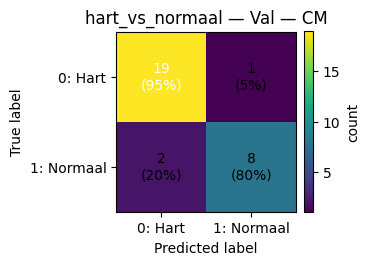

hart_vs_normaal — Test — Accuracy: 0.875
Label mapping: 0 = 'Hart', 1 = 'Normaal'


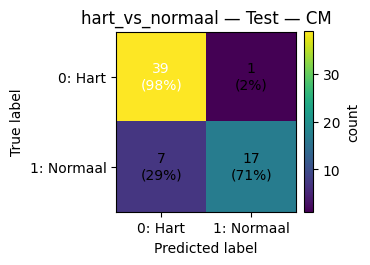

INFO:tensorflow:Assets written to: C:\Users\ESMEEW~1\AppData\Local\Temp\tmpiy9rcwha\assets


INFO:tensorflow:Assets written to: C:\Users\ESMEEW~1\AppData\Local\Temp\tmpiy9rcwha\assets


Saved artifact at 'C:\Users\ESMEEW~1\AppData\Local\Temp\tmpiy9rcwha'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 513, 182, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1494206802512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1494206802704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1494275577744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1494275579664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1494275571792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1494275580624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1494275579088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1494275580816: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\Lungsound-Annotation-Tool\experiments\models\cnn_hart_vs_normaal.tflite
{'input_

In [11]:
# 1) Hart vs Normaal
model_hn, stats_hn = run_experiment("Hart", "Normaal", "hart_vs_normaal")
print(stats_hn)


=== Experiment: Hart vs Hoest ===
Number of segments: 254 | {'Hart': 200, 'Hoest': 54}
[balanced] y-train {0: 140, 1: 37} | y-val {0: 20, 1: 5} | y-test {0: 40, 1: 12}
Shapes: 
  train: (177, 513, 182, 1) 
  val  : (25, 513, 182, 1) 
  test : (52, 513, 182, 1)
Epoch 1/40
6/6 - 2s - 407ms/step - accuracy: 0.5424 - loss: 16.9976 - val_accuracy: 0.1200 - val_loss: 22.1289 - learning_rate: 1.0000e-03
Epoch 2/40
6/6 - 2s - 302ms/step - accuracy: 0.6836 - loss: 1.8783 - val_accuracy: 0.8800 - val_loss: 1.8040 - learning_rate: 1.0000e-03
Epoch 3/40
6/6 - 2s - 298ms/step - accuracy: 0.8927 - loss: 0.4268 - val_accuracy: 0.8800 - val_loss: 0.9628 - learning_rate: 1.0000e-03
Epoch 4/40
6/6 - 2s - 292ms/step - accuracy: 0.8983 - loss: 0.3806 - val_accuracy: 0.9200 - val_loss: 0.5055 - learning_rate: 1.0000e-03
Epoch 5/40
6/6 - 2s - 292ms/step - accuracy: 0.9322 - loss: 0.3219 - val_accuracy: 0.9600 - val_loss: 0.3869 - learning_rate: 1.0000e-03
Epoch 6/40
6/6 - 2s - 289ms/step - accuracy: 0.9548

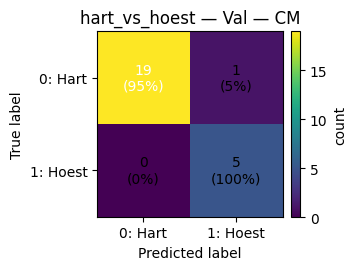

hart_vs_hoest — Test — Accuracy: 0.885
Label mapping: 0 = 'Hart', 1 = 'Hoest'


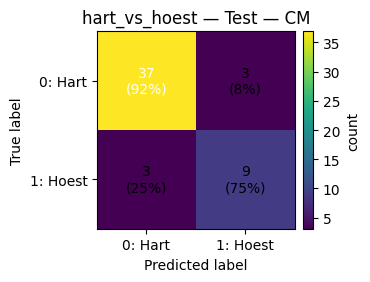

INFO:tensorflow:Assets written to: C:\Users\ESMEEW~1\AppData\Local\Temp\tmpe75j2lxs\assets


INFO:tensorflow:Assets written to: C:\Users\ESMEEW~1\AppData\Local\Temp\tmpe75j2lxs\assets


Saved artifact at 'C:\Users\ESMEEW~1\AppData\Local\Temp\tmpe75j2lxs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 513, 182, 1), dtype=tf.float32, name='keras_tensor_8')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1492797640720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1492797639184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1492797646096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1492797647056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1492797648976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1492797643408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1492797645520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1492797640912: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\Lungsound-Annotation-Tool\experiments\models\cnn_hart_vs_hoest.tflite
{'input_

In [12]:
# 2) Normaal vs Hoest
model_hh, stats_hh = run_experiment("Hart", "Hoest",   "hart_vs_hoest")
print(stats_hh)


=== Experiment: Hoest vs Normaal ===
Number of segments: 169 | {'Normaal': 115, 'Hoest': 54}
[balanced] y-train {1: 94, 0: 27} | y-val {0: 11, 1: 3} | y-test {1: 18, 0: 16}
Shapes: 
  train: (121, 513, 182, 1) 
  val  : (14, 513, 182, 1) 
  test : (34, 513, 182, 1)
Epoch 1/40
4/4 - 2s - 577ms/step - accuracy: 0.4711 - loss: 34.1811 - val_accuracy: 1.0000 - val_loss: 0.0392 - learning_rate: 1.0000e-03
Epoch 2/40
4/4 - 1s - 288ms/step - accuracy: 0.8017 - loss: 1.5488 - val_accuracy: 1.0000 - val_loss: 0.0025 - learning_rate: 1.0000e-03
Epoch 3/40
4/4 - 1s - 288ms/step - accuracy: 0.9835 - loss: 0.2330 - val_accuracy: 1.0000 - val_loss: 5.2281e-06 - learning_rate: 1.0000e-03
Epoch 4/40
4/4 - 1s - 284ms/step - accuracy: 1.0000 - loss: 4.6441e-04 - val_accuracy: 1.0000 - val_loss: 5.3644e-07 - learning_rate: 1.0000e-03
Epoch 5/40

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 - 1s - 286ms/step - accuracy: 1.0000 - loss: 8.2444e-06 - val_accuracy: 1.0000 -

hoest_vs_normaal — Val — Accuracy: 1.000
Label mapping: 0 = 'Hoest', 1 = 'Normaal'


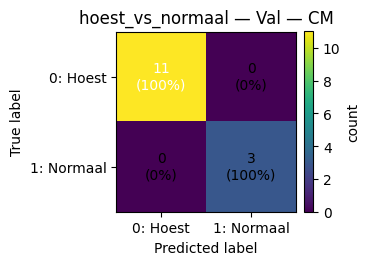

hoest_vs_normaal — Test — Accuracy: 0.941
Label mapping: 0 = 'Hoest', 1 = 'Normaal'


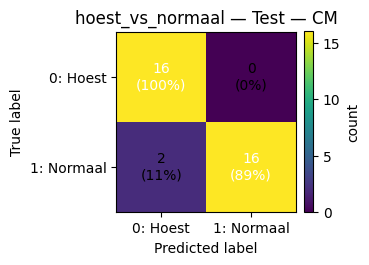

INFO:tensorflow:Assets written to: C:\Users\ESMEEW~1\AppData\Local\Temp\tmp8t_ktqy7\assets


INFO:tensorflow:Assets written to: C:\Users\ESMEEW~1\AppData\Local\Temp\tmp8t_ktqy7\assets


Saved artifact at 'C:\Users\ESMEEW~1\AppData\Local\Temp\tmp8t_ktqy7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 513, 182, 1), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1492657057872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1492657052688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1492657059600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1492657052496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1492657045776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1492657045584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1492657047888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1492657047312: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\Lungsound-Annotation-Tool\experiments\models\cnn_hoest_vs_normaal.tflite
{'in

In [13]:
# 3) Hoest vs Hart
model_hn2, stats_hn2= run_experiment("Hoest","Normaal","hoest_vs_normaal")
print(stats_hn2)